In [1]:
from global_variables import spark
from pyspark.sql import functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
household_info = spark.read.csv("../data/archive/informations_households.csv", header=True)
electricity_consumption = spark.read.csv("../data/archive/daily_dataset.csv", header=True)
weather = spark.read.csv('../data/archive/weather_daily_darksky.csv', header=True)

# EDA household_info

In [3]:
df = household_info.toPandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LCLid          5566 non-null   object
 1   stdorToU       5566 non-null   object
 2   Acorn          5566 non-null   object
 3   Acorn_grouped  5566 non-null   object
 4   file           5566 non-null   object
dtypes: object(5)
memory usage: 217.6+ KB


In [4]:
df.describe()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
count,5566,5566,5566,5566,5566
unique,5566,2,19,5,112
top,MAC002774,Std,ACORN-E,Affluent,block_0
freq,1,4443,1567,2192,50


Here we see that most of the people who were a part of this study were Established people

In [6]:
household_info.show()

+---------+--------+-------+-------------+-------+
|    LCLid|stdorToU|  Acorn|Acorn_grouped|   file|
+---------+--------+-------+-------------+-------+
|MAC005492|     ToU| ACORN-|       ACORN-|block_0|
|MAC001074|     ToU| ACORN-|       ACORN-|block_0|
|MAC000002|     Std|ACORN-A|     Affluent|block_0|
|MAC003613|     Std|ACORN-A|     Affluent|block_0|
|MAC003597|     Std|ACORN-A|     Affluent|block_0|
|MAC003579|     Std|ACORN-A|     Affluent|block_0|
|MAC003566|     Std|ACORN-A|     Affluent|block_0|
|MAC003557|     Std|ACORN-A|     Affluent|block_0|
|MAC003553|     Std|ACORN-A|     Affluent|block_0|
|MAC003482|     Std|ACORN-A|     Affluent|block_0|
|MAC003463|     Std|ACORN-A|     Affluent|block_0|
|MAC003449|     Std|ACORN-A|     Affluent|block_0|
|MAC003428|     Std|ACORN-A|     Affluent|block_0|
|MAC003423|     Std|ACORN-A|     Affluent|block_0|
|MAC003422|     Std|ACORN-A|     Affluent|block_0|
|MAC003400|     Std|ACORN-A|     Affluent|block_0|
|MAC003394|     Std|ACORN-A|   

In [3]:
household_info.select("Acorn_grouped").distinct().show()

+-------------+
|Acorn_grouped|
+-------------+
|    Adversity|
|       ACORN-|
|     Affluent|
|      ACORN-U|
|  Comfortable|
+-------------+



We don't really need the information on where the data is located or the kind of tariff applied.

In [3]:
household_info = household_info.drop("file", "Acorn_grouped", "stdorToU")

In [7]:
household_info.select("Acorn").distinct().orderBy("Acorn").show()

+-------+
|  Acorn|
+-------+
|ACORN-A|
|ACORN-B|
|ACORN-C|
|ACORN-D|
|ACORN-E|
|ACORN-F|
|ACORN-G|
|ACORN-H|
|ACORN-I|
|ACORN-J|
|ACORN-K|
|ACORN-L|
|ACORN-M|
|ACORN-N|
|ACORN-O|
|ACORN-P|
|ACORN-Q|
|ACORN-U|
+-------+



In [4]:
household_info.where("Acorn = 'ACORN-'").show()
id_to_drop = household_info.where("Acorn = 'ACORN-'").toPandas()["LCLid"].tolist()
print(id_to_drop)

+---------+------+
|    LCLid| Acorn|
+---------+------+
|MAC005492|ACORN-|
|MAC001074|ACORN-|
+---------+------+

['MAC005492', 'MAC001074']


we don't have the acorn for these houses it is better to remove those IDs

In [5]:
household_info = household_info.where("Acorn != 'ACORN-'")

In [6]:
acorn_list = household_info.select('Acorn').distinct().orderBy('Acorn').toPandas()['Acorn'].tolist()

In [7]:
household_info = household_info.withColumn('Acorn_id', F.lit(0))

In [8]:
def conditional_update(df, condition_col, condition_val, update_col, new_val):
    '''
    .withColumn => used to update a column
    .when => returns a value when condition is true
    '''
    return df.withColumn(update_col, F.when(F.col(condition_col) == condition_val, new_val).otherwise(F.col(update_col)))

for index in range(len(acorn_list)):
    household_info = conditional_update(household_info, 'Acorn', acorn_list[index], 'Acorn_id', index+1)

# EDA electricity consumption

In [9]:
electricity_consumption.show()

+---------+----------+-------------------+-------------------+------------------+------------+-------------------+------------------+-------------------+
|    LCLid|       day|      energy_median|        energy_mean|        energy_max|energy_count|         energy_std|        energy_sum|         energy_min|
+---------+----------+-------------------+-------------------+------------------+------------+-------------------+------------------+-------------------+
|MAC000131|2011-12-15|              0.485|0.43204545454545457|             0.868|          22|0.23914579678767536|             9.505|0.07200000000000001|
|MAC000131|2011-12-16|             0.1415|0.29616666875000003|         1.1160001|          48| 0.2814713178628203|14.216000100000002|              0.031|
|MAC000131|2011-12-17|             0.1015|          0.1898125|             0.685|          48| 0.1884046862418033|             9.111|              0.064|
|MAC000131|2011-12-18|              0.114| 0.2189791666666666|0.675999999999

In [9]:
df = pd.read_csv(f"../data/archive/daily_dataset.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   LCLid          object 
 1   day            object 
 2   energy_median  float64
 3   energy_mean    float64
 4   energy_max     float64
 5   energy_count   int64  
 6   energy_std     float64
 7   energy_sum     float64
 8   energy_min     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 241.0+ MB


In [21]:
df.describe()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,3.510403e+06,3.510403e+06,3.510403e+06,3.510433e+06,3.499102e+06,3.510403e+06,3.510403e+06
mean,1.587395e-01,2.117305e-01,8.345210e-01,4.780364e+01,1.726673e-01,1.012414e+01,5.962578e-02
std,1.701865e-01,1.908460e-01,6.683156e-01,2.810982e+00,1.531208e-01,9.128793e+00,8.701312e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.700000e-02,9.808333e-02,3.460000e-01,4.800000e+01,6.911626e-02,4.682000e+00,2.000000e-02
50%,1.145000e-01,1.632917e-01,6.880000e-01,4.800000e+01,1.327910e-01,7.815000e+00,3.900000e-02
75%,1.910000e-01,2.624583e-01,1.128000e+00,4.800000e+01,2.293124e-01,1.256900e+01,7.100000e-02
max,6.970500e+00,6.928250e+00,1.076100e+01,4.800000e+01,4.024569e+00,3.325560e+02,6.524000e+00


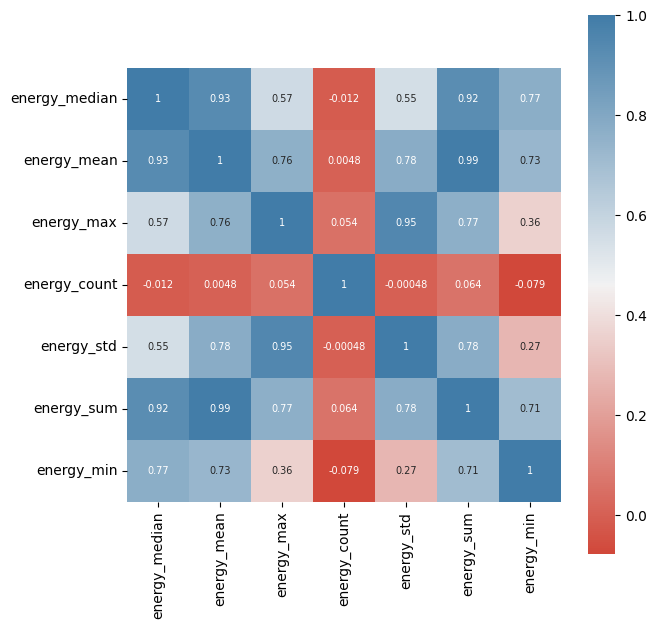

In [84]:
corrMatrix = df[df.select_dtypes(include=['float64', 'int64']).columns].corr()
plt.figure(figsize =(7,7))
plt.rc('font', size=7)
plt.rc('axes', labelsize=7, titlesize=7)
cmap = sns.diverging_palette(15, -3000, as_cmap=True)
fig = sns.heatmap(corrMatrix , annot=True , square=True ,cmap=cmap)

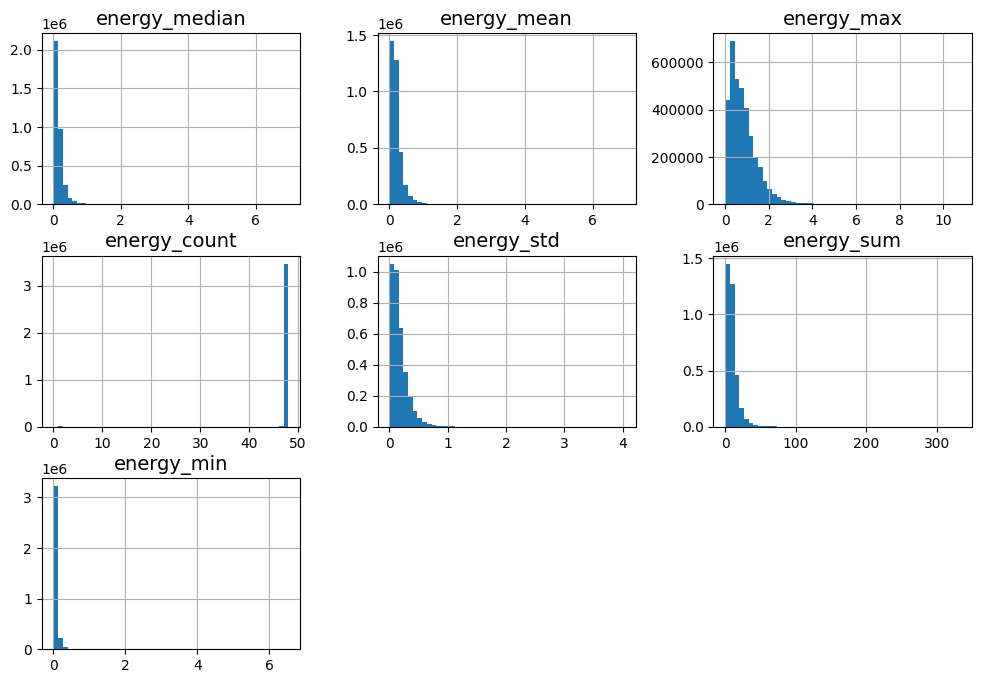

In [35]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
plt.show()

We don't really need columns other than energy_sum

In [ ]:
electricity_consumption.columns

['LCLid',
 'day',
 'energy_median',
 'energy_mean',
 'energy_max',
 'energy_count',
 'energy_std',
 'energy_sum',
 'energy_min']

In [10]:
electricity_consumption = electricity_consumption.select('LCLid', 'day', 'energy_sum')

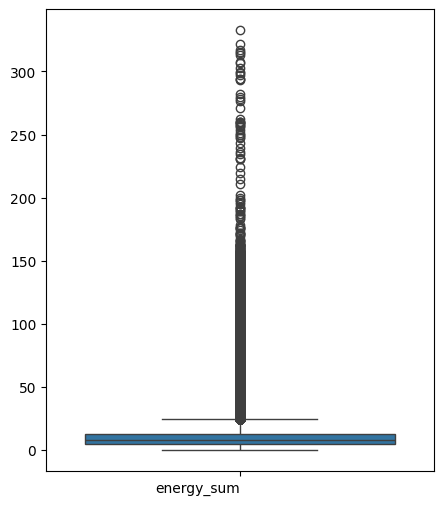

In [60]:
plt.figure(figsize=(5, 6))
sns.boxplot(data=df.loc[:, df.columns.isin(['energy_sum'])])

# Slant the x-axis labels
plt.xticks(ha="right")
plt.show()

In [12]:
electricity_consumption.show()

+---------+----------+------------------+
|    LCLid|       day|        energy_sum|
+---------+----------+------------------+
|MAC000131|2011-12-15|             9.505|
|MAC000131|2011-12-16|14.216000100000002|
|MAC000131|2011-12-17|             9.111|
|MAC000131|2011-12-18|10.510999999999996|
|MAC000131|2011-12-19|15.646999999999998|
|MAC000131|2011-12-20|             17.16|
|MAC000131|2011-12-21|            11.284|
|MAC000131|2011-12-22|            10.625|
|MAC000131|2011-12-23|13.973999999999998|
|MAC000131|2011-12-24|             7.943|
|MAC000131|2011-12-25|16.281000000000002|
|MAC000131|2011-12-26|12.562000000000001|
|MAC000131|2011-12-27|13.152000000000005|
|MAC000131|2011-12-28|            14.425|
|MAC000131|2011-12-29|            14.738|
|MAC000131|2011-12-30|13.289000000000005|
|MAC000131|2011-12-31|15.635000000000005|
|MAC000131|2012-01-01|            12.289|
|MAC000131|2012-01-02|              12.1|
|MAC000131|2012-01-03|11.304000000000002|
+---------+----------+------------

In [10]:
household_info.show()

+---------+-------+--------+
|    LCLid|  Acorn|Acorn_id|
+---------+-------+--------+
|MAC000002|ACORN-A|       1|
|MAC003613|ACORN-A|       1|
|MAC003597|ACORN-A|       1|
|MAC003579|ACORN-A|       1|
|MAC003566|ACORN-A|       1|
|MAC003557|ACORN-A|       1|
|MAC003553|ACORN-A|       1|
|MAC003482|ACORN-A|       1|
|MAC003463|ACORN-A|       1|
|MAC003449|ACORN-A|       1|
|MAC003428|ACORN-A|       1|
|MAC003423|ACORN-A|       1|
|MAC003422|ACORN-A|       1|
|MAC003400|ACORN-A|       1|
|MAC003394|ACORN-A|       1|
|MAC003388|ACORN-A|       1|
|MAC003348|ACORN-A|       1|
|MAC000246|ACORN-A|       1|
|MAC003305|ACORN-A|       1|
|MAC003281|ACORN-A|       1|
+---------+-------+--------+
only showing top 20 rows



In [11]:
electricity_consumption = electricity_consumption.withColumnRenamed('LCLid', 'id')
energy_info = household_info.join(electricity_consumption, household_info.LCLid == electricity_consumption.id, how='left').drop('id')

# EDA weather

In [15]:
weather.show()

+--------------+-------------------+-----------+-------------------+--------+-------------------+----------+---------+--------+--------------------------+-----------------------+----------+----------+--------+---------------------------+----------------------+----------------------+-------+-------------------+-------------------+--------------+--------------+---------------+-------------------+-------------------+-------------------+--------------------+-------------------+----------------------+--------------------------+--------------------------+---------+
|temperatureMax| temperatureMaxTime|windBearing|               icon|dewPoint| temperatureMinTime|cloudCover|windSpeed|pressure|apparentTemperatureMinTime|apparentTemperatureHigh|precipType|visibility|humidity|apparentTemperatureHighTime|apparentTemperatureLow|apparentTemperatureMax|uvIndex|               time|         sunsetTime|temperatureLow|temperatureMin|temperatureHigh|        sunriseTime|temperatureHighTime|        uvIndexTi

In [12]:
weather = weather.withColumn("date", F.to_date("sunriseTime"))

In [12]:
weather.columns

['temperatureMax',
 'temperatureMaxTime',
 'windBearing',
 'icon',
 'dewPoint',
 'temperatureMinTime',
 'cloudCover',
 'windSpeed',
 'pressure',
 'apparentTemperatureMinTime',
 'apparentTemperatureHigh',
 'precipType',
 'visibility',
 'humidity',
 'apparentTemperatureHighTime',
 'apparentTemperatureLow',
 'apparentTemperatureMax',
 'uvIndex',
 'time',
 'sunsetTime',
 'temperatureLow',
 'temperatureMin',
 'temperatureHigh',
 'sunriseTime',
 'temperatureHighTime',
 'uvIndexTime',
 'summary',
 'temperatureLowTime',
 'apparentTemperatureMin',
 'apparentTemperatureMaxTime',
 'apparentTemperatureLowTime',
 'moonPhase',
 'date']

In [20]:
weather.drop('temperatureMaxTime', 'temperatureMinTime', 'apparentTemperatureMinTime', 'apparentTemperatureHighTime', 'temperatureHighTime', 'uvIndexTime', 'summary', 'temperatureLowTime', 'apparentTemperatureMaxTime', 'apparentTemperatureLowTime', 'icon', 'time', 'precipType').show()

+--------------+-----------+--------+----------+---------+--------+-----------------------+----------+--------+----------------------+----------------------+-------+-------------------+--------------+--------------+---------------+-------------------+----------------------+---------+----------+
|temperatureMax|windBearing|dewPoint|cloudCover|windSpeed|pressure|apparentTemperatureHigh|visibility|humidity|apparentTemperatureLow|apparentTemperatureMax|uvIndex|         sunsetTime|temperatureLow|temperatureMin|temperatureHigh|        sunriseTime|apparentTemperatureMin|moonPhase|      date|
+--------------+-----------+--------+----------+---------+--------+-----------------------+----------+--------+----------------------+----------------------+-------+-------------------+--------------+--------------+---------------+-------------------+----------------------+---------+----------+
|         11.96|        123|     9.4|      0.79|     3.88| 1016.08|                  10.87|       3.3|    0.95| 

In [21]:
weather.select('uvIndex').distinct().collect()

[Row(uvIndex='1.0'),
 Row(uvIndex='0.0'),
 Row(uvIndex='5.0'),
 Row(uvIndex='6.0'),
 Row(uvIndex='4.0'),
 Row(uvIndex='7.0'),
 Row(uvIndex='2.0'),
 Row(uvIndex='3.0'),
 Row(uvIndex=None)]

In [13]:
weather = weather.drop('temperatureMaxTime', 'temperatureMinTime', 'apparentTemperatureMinTime', 'apparentTemperatureHighTime', 'temperatureHighTime', 'uvIndexTime', 'summary', 'temperatureLowTime', 'apparentTemperatureMaxTime', 'apparentTemperatureLowTime', 'icon', 'time', 'precipType').withColumn('sunsetTime', F.date_format('sunsetTime', 'HH:mm:ss')).withColumn('sunriseTime', F.date_format('sunriseTime', 'HH:mm:ss'))

In [25]:
energy_info.show()

+---------+-------+--------+----------+------------------+
|    LCLid|  Acorn|Acorn_id|       day|        energy_sum|
+---------+-------+--------+----------+------------------+
|MAC003252|ACORN-A|       1|2012-09-19| 8.568999999999999|
|MAC003252|ACORN-A|       1|2012-09-20|            10.661|
|MAC003252|ACORN-A|       1|2012-09-21|14.054999999999998|
|MAC003252|ACORN-A|       1|2012-09-22|            15.648|
|MAC003252|ACORN-A|       1|2012-09-23|             8.701|
|MAC003252|ACORN-A|       1|2012-09-24|             0.112|
|MAC003252|ACORN-A|       1|2012-09-25|            11.691|
|MAC003252|ACORN-A|       1|2012-09-26|12.395999999999999|
|MAC003252|ACORN-A|       1|2012-09-27|        11.1180001|
|MAC003252|ACORN-A|       1|2012-09-28|            11.385|
|MAC003252|ACORN-A|       1|2012-09-29|14.514000000000001|
|MAC003252|ACORN-A|       1|2012-09-30|            12.262|
|MAC003252|ACORN-A|       1|2012-10-01|            13.662|
|MAC003252|ACORN-A|       1|2012-10-02|11.49599999999999

In [14]:
energy_info = energy_info.join(weather, energy_info.day == weather.date, how='left').drop('day')

In [15]:
energy_info.show()

+---------+-------+--------+------------------+--------------+-----------+--------+----------+---------+--------+-----------------------+----------+--------+----------------------+----------------------+-------+----------+--------------+--------------+---------------+-----------+----------------------+---------+----------+
|    LCLid|  Acorn|Acorn_id|        energy_sum|temperatureMax|windBearing|dewPoint|cloudCover|windSpeed|pressure|apparentTemperatureHigh|visibility|humidity|apparentTemperatureLow|apparentTemperatureMax|uvIndex|sunsetTime|temperatureLow|temperatureMin|temperatureHigh|sunriseTime|apparentTemperatureMin|moonPhase|      date|
+---------+-------+--------+------------------+--------------+-----------+--------+----------+---------+--------+-----------------------+----------+--------+----------------------+----------------------+-------+----------+--------------+--------------+---------------+-----------+----------------------+---------+----------+
|MAC003252|ACORN-A|      

# Energy EDA

In [17]:
energy_info.show()

+---------+-------+--------+------------------+--------------+-----------+--------+----------+---------+--------+-----------------------+----------+--------+----------------------+----------------------+-------+----------+--------------+--------------+---------------+-----------+----------------------+---------+----------+
|    LCLid|  Acorn|Acorn_id|        energy_sum|temperatureMax|windBearing|dewPoint|cloudCover|windSpeed|pressure|apparentTemperatureHigh|visibility|humidity|apparentTemperatureLow|apparentTemperatureMax|uvIndex|sunsetTime|temperatureLow|temperatureMin|temperatureHigh|sunriseTime|apparentTemperatureMin|moonPhase|      date|
+---------+-------+--------+------------------+--------------+-----------+--------+----------+---------+--------+-----------------------+----------+--------+----------------------+----------------------+-------+----------+--------------+--------------+---------------+-----------+----------------------+---------+----------+
|MAC003252|ACORN-A|      

In [16]:
spark.version

'3.5.1'